364736.64


Start date,2023-02-01
End date,2023-06-30
Total months,7
,Backtest
Annual return,38.9%
Cumulative returns,21.6%
Annual volatility,8.7%
Sharpe ratio,3.81
Calmar ratio,10.68
Stability,0.80
Max drawdown,-3.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.64,2023-04-12,2023-04-25,2023-05-18,27
1,3.10,2023-03-07,2023-03-16,2023-03-31,19
2,1.98,2023-06-25,2023-06-27,NaT,NaN
3,0.92,2023-06-18,2023-06-20,2023-06-21,3
4,0.70,2023-06-07,2023-06-08,2023-06-09,3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Stress Events,mean,min,max
New Normal,0.13%,-1.80%,1.73%


unit: 37500, balance: 0
BUY EXECUTED, Price: 532.00, Size: 70.00, Comm 53.00, Cost 37293.00, Cash 207.00
2023-02-15 trigger support 525.0<528.65
SELL EXECUTED, Price: 528.00, Size: -70.00, Comm 163.00, Profit 36797.00, Cash 37004.00
2330 returns: -1.3227%
--------------------------------------------------
BUY EXECUTED, Price: 2135.00, Size: 17.00, Comm 51.00, Cost 36346.00, Cash 1154.00
SELL EXECUTED, Price: 2245.00, Size: -17.00, Comm 168.00, Profit 37997.00, Cash 39151.00
3008 returns: 4.4027%
--------------------------------------------------
BUY EXECUTED, Price: 173.50, Size: 215.00, Comm 53.00, Cost 37355.50, Cash 144.50
SELL EXECUTED, Price: 181.00, Size: -215.00, Comm 172.00, Profit 38743.00, Cash 38887.50
1707 returns: 3.7%
--------------------------------------------------
BUY EXECUTED, Price: 757.00, Size: 49.00, Comm 52.00, Cost 37145.00, Cash 355.00
2023-02-13 trigger support 814.0<815.77
SELL EXECUTED, Price: 822.00, Size: -49.00, Comm 178.00, Profit 40100.00, Cash 40455.0

Start date,2023-02-01
End date,2023-06-30
Total months,7
,Backtest
Annual return,32.5%
Cumulative returns,18.2%
Annual volatility,11.6%
Sharpe ratio,2.47
Calmar ratio,4.78
Stability,0.83
Max drawdown,-6.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.79,2023-04-17,2023-05-11,2023-06-05,36
1,2.95,2023-03-07,2023-03-14,2023-04-11,26
2,2.17,2023-02-09,2023-02-17,2023-03-01,15
3,2.04,2023-06-07,2023-06-08,2023-06-15,7
4,1.88,2023-06-18,2023-06-30,NaT,NaN


Stress Events,mean,min,max
New Normal,0.11%,-2.04%,2.62%


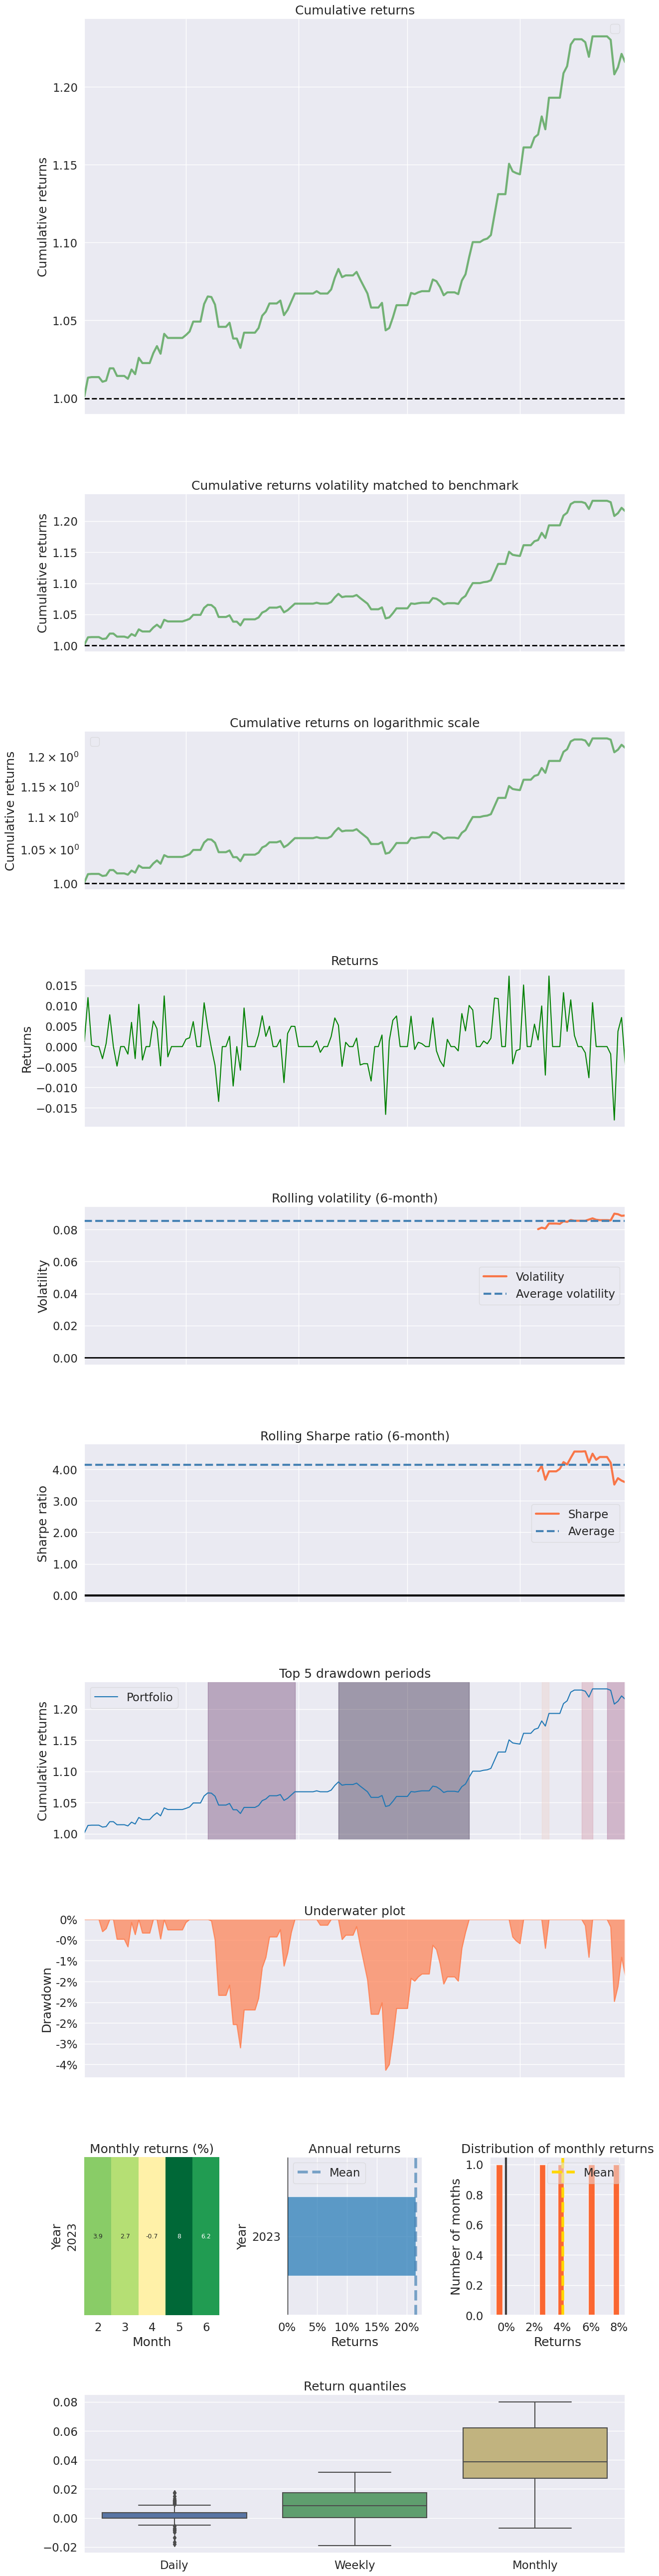

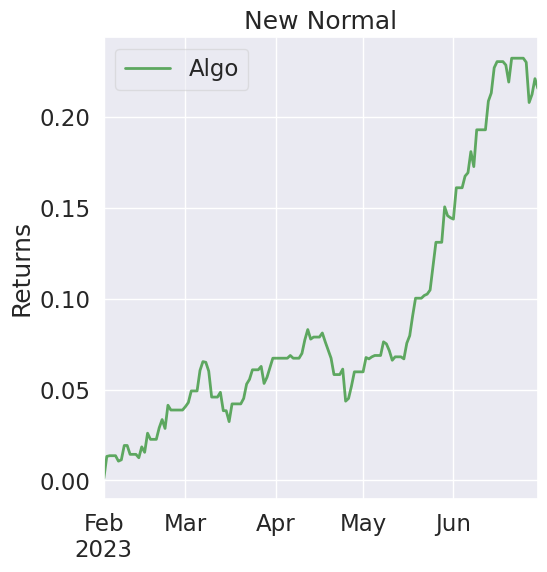

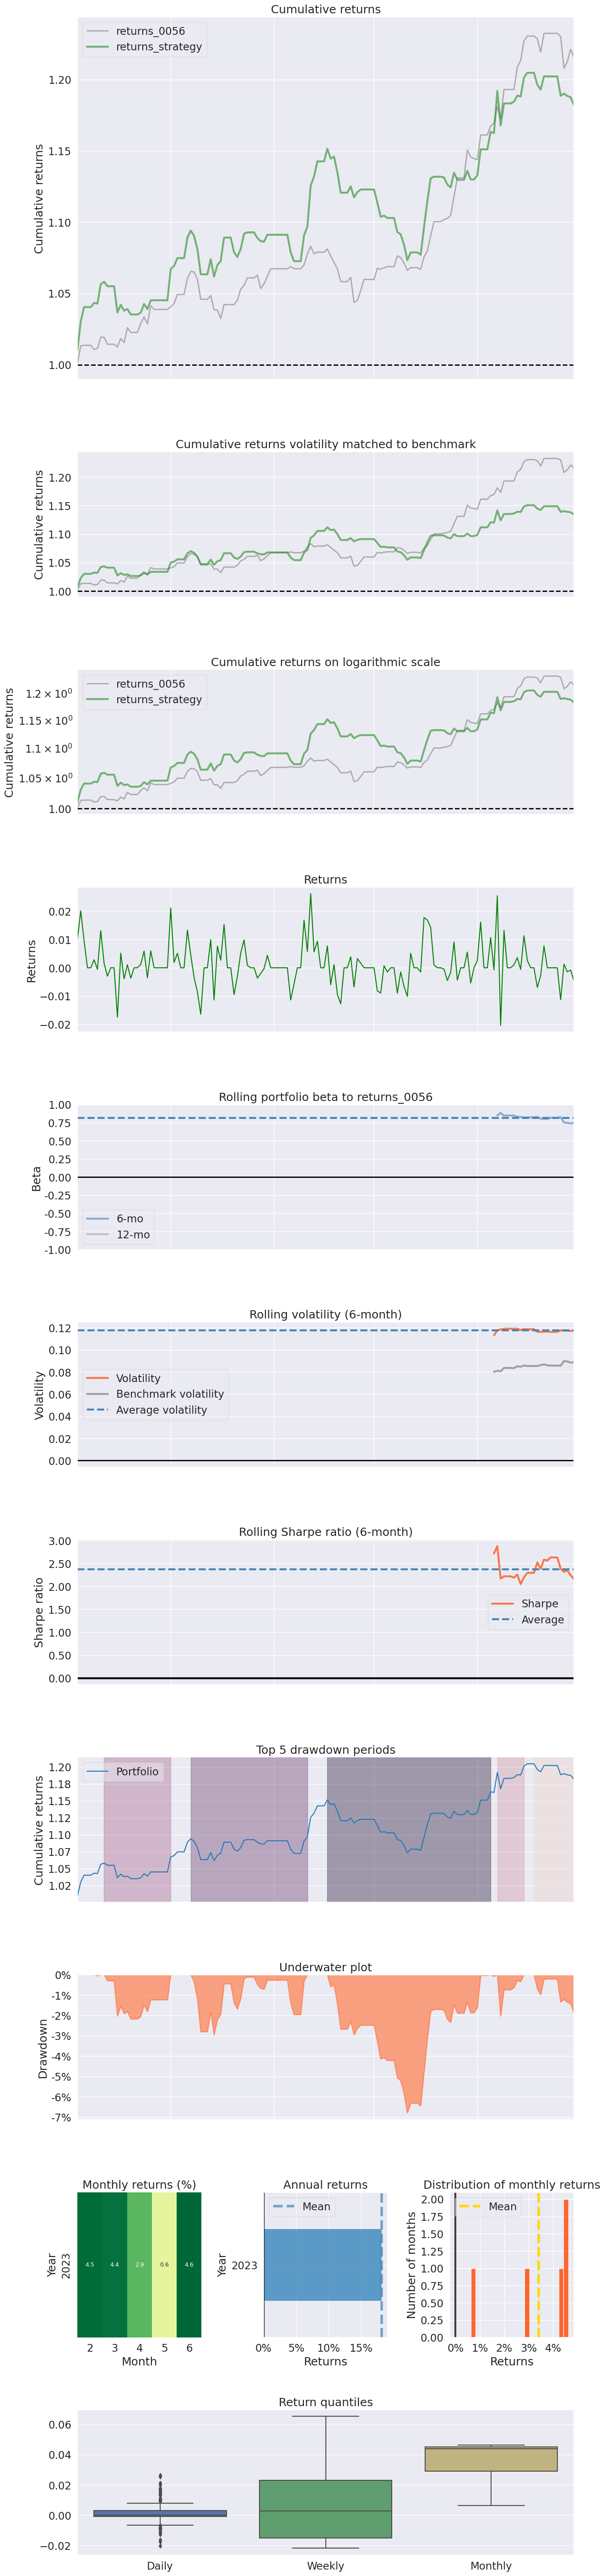

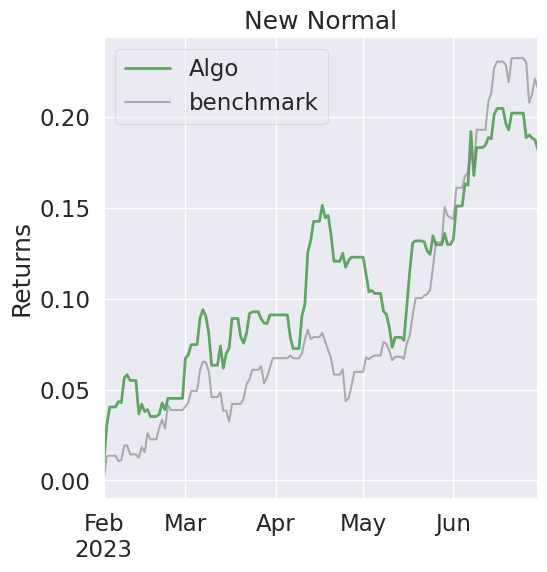

In [7]:
import backtrader as bt
import yfinance as yf
import pandas as pd
from datetime import datetime, timezone, timedelta
import pyfolio as pf
from typing import Tuple
import warnings
import time
import math
warnings.filterwarnings('ignore')

class CustomCommission(bt.CommInfoBase):
    # 證交稅跟手續費
    params = (
        ('stampduty', 0.003),
        ('commission', 0.001425),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_PERC),
        ('minCommission', 20),
        ('percabs', True),
    )

    def _getcommission(self, size, price, pseudoexec):
        fee = 0

        if size > 0:
            fee = max(size * price * self.p.commission, self.p.minCommission)
        elif size < 0:
            fee = max(abs(size) * price * self.p.commission, self.p.minCommission) + abs(size) * price * self.p.stampduty

        return int(fee)

class PopularTickerStrategy(bt.Strategy):
    params = (
        ('support', 0.03),
        ('commission', 0.001425),
    )

    def __init__(self, params = None) -> None:
        if params != None:
            for name, val in params.items():
                setattr(self.params, name, val)

        self.last_bar = len(self.datas[0].array) - 1
        self.is_buy = False
        self.support = 0
        self.resistance = 0
        self.size = 0
    
    # def notify_cashvalue(self, cash, value):
    #     print(f"Date: {self.data.datetime.date(0).strftime('%Y-%m-%d')}, Cash: {cash}, Value: {value}")

    def notify_order(self, order):
        # print(order)
        # print("*****"*10)

        if order.status in [order.Margin]:
            print("Margin")

        if order.status in [order.Completed]:
            if order.isbuy():
                print(
                    "BUY EXECUTED, Price: %.2f, Size: %.2f, Comm %.2f, Cost %.2f, Cash %.2f"
                    % (
                        order.executed.price,
                        order.executed.size,
                        order.executed.comm,
                        order.executed.price * order.executed.size + order.executed.comm,
                        self.broker.getcash(),
                    )
                )
            else:
                if order.exectype == bt.Order.StopTrail:
                    print(
                        "Stop Trail SELL EXECUTED, Price: %.2f, Size: %.2f, Comm %.2f, Profit %.2f, Cash %.2f"
                        % (
                            order.executed.price,
                            order.executed.size,
                            order.executed.comm,
                            order.executed.price * (-order.executed.size) - order.executed.comm,
                            self.broker.getcash(),
                        )
                    )
                else:
                    print(
                        "SELL EXECUTED, Price: %.2f, Size: %.2f, Comm %.2f, Profit %.2f, Cash %.2f"
                        % (
                            order.executed.price,
                            order.executed.size,
                            order.executed.comm,
                            order.executed.price * (-order.executed.size) - order.executed.comm,
                            self.broker.getcash(),
                        )
                    )

    def next(self) -> None:
        if ((self.position) and
            (len(self) == self.last_bar)):
            self.close()

        if self.data.close[0] < self.support:
            if ((self.position) and
                (len(self) < self.last_bar)):
                print(f"{self.data.datetime.date(0).strftime('%Y-%m-%d')} trigger support {self.data.close[0]}<{self.support}")
                self.close()
    
        self.support = round(self.data.close[0] * (1 - self.p.support), 2)

    def next_open(self) -> None:
        if ((not self.position) and
            (not self.is_buy)):
            self.size = int(self.broker.getcash() / (self.data.open[0] * (1 + self.p.commission)))
            self.buy(size = self.size)

            self.support = round(self.data.close[0] * (1 - self.p.support), 2)
            self.is_buy = True


class ETFStrategy(bt.Strategy):
    params = (
        ('commission', 0.001425),
    )

    def __init__(self, params = None) -> None:
        if params != None:
            for name, val in params.items():
                setattr(self.params, name, val)

        self.last_bar = len(self.datas[0].array) - 1
    
    # def notify_cashvalue(self, cash, value):
    #     print(f"Date: {self.data.datetime.date(0).strftime('%Y-%m-%d')}, Cash: {cash}, Value: {value}")

    def notify_order(self, order):
        if order.status in [order.Margin]:
            print("Margin")

        # if order.status in [order.Completed]:
        #     if order.isbuy():
        #         print(
        #             "BUY EXECUTED, Price: %.2f, Size: %.2f, Comm %.2f, Cost %.2f, Cash %.2f"
        #             % (
        #                 order.executed.price,
        #                 order.executed.size,
        #                 order.executed.comm,
        #                 order.executed.price * order.executed.size + order.executed.comm,
        #                 self.broker.getcash(),
        #             )
        #         )
        #     else:
        #         print(
        #             "SELL EXECUTED, Price: %.2f, Size: %.2f, Comm %.2f, Profit %.2f, Cash %.2f"
        #             % (
        #                 order.executed.price,
        #                 order.executed.size,
        #                 order.executed.comm,
        #                 order.executed.price * (-order.executed.size) - order.executed.comm,
        #                 self.broker.getcash(),
        #             )
        #         )

    def next(self) -> None:
        if ((self.position) and
            (len(self) == self.last_bar)):
            self.close()
    
    def next_open(self) -> None:
        if not self.position:
            size = int(self.broker.getcash() / (self.data.open[0] * (1 + self.p.commission)))
            self.buy(size = size)


class HandleBackTrader():
    def __init__(self) -> None:
        self.cerebro = None
        self.cash_unit = 300000
        self.settings = {
                            "commission" : 0.001425,
                            "stampduty" : 0.003
                        }
        self.CustomCommission = CustomCommission(commission = self.settings["commission"], stampduty = self.settings["stampduty"])

    def _init_interval_returns(self, start_date : str, end_date : str) -> pd.Series:
        index = []
        data = {}

        start_date = datetime.strptime(start_date, '%Y-%m-%d').replace(tzinfo = timezone.utc)
        end_date = datetime.strptime(end_date, '%Y-%m-%d').replace(tzinfo = timezone.utc)

        while start_date <= end_date:
            index.append(start_date)
            data[start_date] = 0.00

            start_date += timedelta(days = 1)
        
        return pd.Series(data, index = index, dtype = float)

    def _get_yahoo_finance_data(self, stock_num : str, start_date : str, type : str = "") -> pd.DataFrame:
        end_date = ""

        if type == "ETF":
            # end_date = datetime.strftime(datetime.now() + timedelta(days = 1), '%Y-%m-%d')
            end_date = "2023-07-01"
        else:
            date = start_date.split("-")
            date[1] = int(date[1]) + 2

            if date[1] > 12:
                date[1] -= 12
                date[0] = int(date[0]) + 1

            end_date = f"{date[0]}-{str(date[1]).zfill(2)}-01"

        while True:
            try:
                result = yf.download(f"{stock_num}.TW", start = start_date, end = end_date, progress = False, show_errors = False)
                
                if result.empty:
                    result = yf.download(f"{stock_num}.TWO", start = start_date, end = end_date, progress = False, show_errors = False)
                break
            except:
                time.sleep(0.1)

        new_index = []

        for i in range(len(result.index)):
            new_index.append(datetime.strptime(result.index[i].strftime('%Y-%m-%d'), '%Y-%m-%d').replace(tzinfo = timezone.utc))

        result.index = new_index

        return result
    
    def _handle_ETF(self, stock_num : str, interval : str, cash : int) -> Tuple[pd.Series, int]:
        self.cerebro = bt.Cerebro(cheat_on_open = True)
        self.cerebro.addstrategy(ETFStrategy, self.settings)

        self.cerebro.broker.setcash(cash)
        self.cerebro.broker.addcommissioninfo(self.CustomCommission)

        data = self._get_yahoo_finance_data(stock_num, interval, "ETF")

        self.cerebro.adddata(bt.feeds.PandasData(dataname = data))
        self.cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'pyfolio')

        results = self.cerebro.run()
        pyfoliozer = results[0].analyzers.getbyname('pyfolio')
        returns, _, _, _ = pyfoliozer.get_pf_items()

        return returns, round(self.cerebro.broker.getvalue(), 2)
    
    def _handle_target(self, stock_list : list, interval : str, cash : int) -> Tuple[pd.Series, int]:
        unit = int(cash / len(stock_list))
        balance = cash - unit * len(stock_list)
        print(f"unit: {unit}, balance: {balance}")
        average_returns = pd.Series(dtype = "float64")
            
        for stock in stock_list:
            self.cerebro = bt.Cerebro(cheat_on_open = True)
            self.cerebro.addstrategy(PopularTickerStrategy, self.settings)
            self.cerebro.broker.setcash(unit)
            self.cerebro.broker.addcommissioninfo(self.CustomCommission)

            data = self._get_yahoo_finance_data(stock, interval)

            self.cerebro.adddata(bt.feeds.PandasData(dataname = data))
            self.cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'pyfolio')

            results = self.cerebro.run()
            pyfoliozer = results[0].analyzers.getbyname('pyfolio')
            returns, _, _, _ = pyfoliozer.get_pf_items()

            if average_returns.empty:
                average_returns = returns
            else:
                average_returns = average_returns.add(returns)

            balance += self.cerebro.broker.getvalue()
            print(f"{stock} returns: {round(100 * (self.cerebro.broker.getvalue() - unit) / unit, 4)}%")
            print("-----"*10)
        average_returns = average_returns.div(len(stock_list))

        return average_returns, round(balance, 2)
    
    def run(self) -> None:
        stocks = {
            "2023-01-31" : ["2330", "3008", "1707", "6669", "2303", "2748", "2408", "5288"],
            "2023-02-24" : ["5347", "2301", "2409", "3711", "4966", "2454", "8454"],
            "2023-03-31" : ["2395", "6488", "2723", "2327", "4551", "2317", "2634", "1590"],
            "2023-04-28" : ["2637", "1590", "2327", "2330", "2408"],
            "2023-05-31" : ["2376", "8069", "2882", "2049", "1476", "1504", "8299", "3661", "8081"],
            # "2023-06-30" : ["2618", "4129", "2634", "2610", "6279", "3217"]
        }
        returns_ETF_result = self._init_interval_returns("2023-01-31", "2023-06-30")
        returns_target_result = self._init_interval_returns("2023-01-31", "2023-06-30")

        ETF_cash = self.cash_unit
        target_cash = self.cash_unit

        # print("ETF")
        ETF = "0056"
        returns_ETF, ETF_cash = self._handle_ETF(ETF, "2023-01-31", ETF_cash)

        for i in range(len(returns_ETF)):
            returns_ETF_result[returns_ETF.index[i]] = returns_ETF[i]
        
        print(ETF_cash)
        pf.create_full_tear_sheet(returns = returns_ETF_result[1:])

        for interval in stocks:
            # print("target")
            temp = target_cash
            returns_target, target_cash = self._handle_target(stocks[interval], interval, target_cash)

            for i in range(len(returns_target)):
                returns_target_result[returns_target.index[i]] = returns_target[i]
            
            print(target_cash)
            print(f"{100 * (target_cash - temp) / temp} %")
            print("====="*10)

        returns_ETF_result.rename(f"returns_{ETF}", inplace = True)
        print(f"Days: {len(returns_target_result[1:])}")
        print(round(returns_target_result[1:].mean(), 5), round(returns_target_result[1:].std(), 5), round(math.sqrt(252) * returns_target_result[1:].mean() / returns_target_result[1:].std(), 3))

        returns_target_result.rename(f"returns_strategy", inplace = True)
        pf.create_full_tear_sheet(returns = returns_target_result[1:], benchmark_rets = returns_ETF_result[1:])
        # pf.create_full_tear_sheet(returns = returns_target_result[-75:-25])

if __name__ == "__main__":
    handle_back_trader = HandleBackTrader()
    handle_back_trader.run()